In [29]:
import nibabel as nib
import os
import glob
import json
from pathlib import Path
import pandas as pd
import subprocess as sub 
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
label_df_lgg = pd.read_csv('/working/lupolab/julia/tcia_analysis/labels_tcia_lgg.csv')
label_df_gbm = pd.read_csv('/working/lupolab/julia/tcia_analysis/labels_tcia_GBM.csv')
full_label_df = label_df_lgg.append(label_df_gbm, ignore_index = True)

In [4]:
label_df_lgg['image'][0]

'/working/lupolab/julia/tcia_analysis/datasets/TCGA-LGG-nifti/TCGA-CS-5396/03-02-2001-MRI_BRAIN_CONTRAST_MRA_BRAIN-47605/305-RT__COW-39894.nii.gz'

In [5]:
full_label_df['patient_id'] = [x.split('/')[7] for x in full_label_df.image]

In [6]:
patient_list = full_label_df.patient_id.unique()

In [7]:
usable_patients = []
for patient in patient_list: 
    patient_df = full_label_df.loc[(full_label_df['patient_id'] == patient) & (full_label_df['ground_truth'] != "OTHER")]
#     print(patient_df)
    if len(patient_df.ground_truth.unique()) >= 4: 
        usable_patients.append(patient)

In [8]:
usable_patient_df = full_label_df.loc[(full_label_df['patient_id'].isin(usable_patients)) & 
                                      (full_label_df['ground_truth'] != "OTHER")].copy()

In [9]:
root_dir = '/working/lupolab/julia/tcia_analysis'


In [10]:
usable_patient_df['aligned_image'] = ['' for x in usable_patient_df.image]

In [11]:
for idx, row in usable_patient_df.iterrows():
    dir_name = '/'.join(row['image'].split('/')[0:-1])
    image_name =row['image'].split('/')[-1]
    image_name_split = image_name.split('.')
    image_name_split[-3] = image_name_split[-3]+'a_n'
    image_name_aligned = '.'.join(image_name_split)
    if image_name_aligned in os.listdir(dir_name): 
        row['aligned_image'] = dir_name+'/'+image_name_aligned
    
    

In [12]:
usable_patient_df['aligned_image'][39]

'/working/lupolab/julia/tcia_analysis/datasets/TCGA-LGG-nifti/TCGA-DU-5853/08-23-1995-MRI_BRAIN_WWO_CONTRAST-78436/12-COR__T1_POST_GD_FLAIR-32689a_n.nii.gz'

In [13]:
def find_patient_images(patient_id, usable_patient_df): 
    images_dict = {}
    patient_images_df = usable_patient_df.loc[usable_patient_df.patient_id == patient_id]
    for x in ['T1C', 'T1', "T2", 'T2_FLAIR']: 
        contrast_images_df = patient_images_df.loc[patient_images_df.ground_truth == x].reset_index(drop = True)
        if contrast_images_df.shape[0] > 1: 
            for idx, row in contrast_images_df.iterrows(): 
                if 'ax'  in row['sd'].lower(): 
                    if row['aligned_image']: 
                        images_dict[x] =  '/'.join(row['aligned_image'].split('/')[6:])
                    else: 
                        images_dict[x] =  '/'.join(row['image'].split('/')[6:])
                    continue
                elif x not in images_dict.keys(): 
                    if row['aligned_image']: 
                        images_dict[x] =  '/'.join(row['aligned_image'].split('/')[6:])
                    else: 
                        images_dict[x] =  '/'.join(row['image'].split('/')[6:])
        else: 
            if contrast_images_df['aligned_image'][0]: 
                images_dict[x] = '/'.join(contrast_images_df['aligned_image'][0].split('/')[6:])
            else: 
                images_dict[x] = '/'.join(contrast_images_df['image'][0].split('/')[6:])
            
    return images_dict

In [14]:
x = list(usable_patient_df.patient_id.unique())

In [15]:
images_dict

NameError: name 'images_dict' is not defined

In [17]:
i =1 
patient_ids_to_remove = []
for patient_id in x: 
    
    images_dict = find_patient_images(patient_id, usable_patient_df)
    
    values = list(images_dict.values())
    root = '/working/lupolab/julia/tcia_analysis/datasets/'
    image1 = nib.load(root+values[0])
    image2 = nib.load(root+values[1])
    image3 = nib.load(root+values[2])
    image4 = nib.load(root+values[3])
    
    check_sizes = image1.shape == image2.shape == image3.shape == image4.shape
    if not check_sizes: 
        print(i)
        print(patient_id)
        patient_ids_to_remove.append(patient_id)
        print(image1.shape, image2.shape, image3.shape, image4.shape)
    i += 1
print(patient_ids_to_remove)

4
TCGA-HT-7684
(240, 240, 187) (240, 240, 187) (240, 240, 1394) (240, 240, 187)
10
TCGA-HT-7690
(240, 240, 180) (240, 240, 180) (240, 240, 390) (240, 240, 180)
20
TCGA-CS-4943
(219, 219, 150) (219, 219, 150) (220, 220, 300) (219, 219, 150)
44
TCGA-CS-4944
(219, 219, 150) (219, 219, 150) (220, 220, 300) (219, 219, 150)
46
TCGA-DU-A6S6
(240, 240, 175) (240, 240, 175) (240, 240, 70) (240, 240, 175)
63
TCGA-HT-8105
(240, 240, 140) (240, 240, 140) (240, 240, 44) (240, 240, 140)
93
TCGA-14-0865
(229, 229, 150) (229, 229, 150) (260, 260, 138) (229, 229, 150)
104
TCGA-06-0156
(240, 240, 66) (240, 240, 66) (240, 240, 110) (240, 240, 165)
105
TCGA-76-6282
(219, 219, 150) (219, 219, 150) (220, 220, 300) (219, 219, 150)
134
TCGA-14-0790
(229, 229, 150) (229, 229, 150) (207, 230, 252) (229, 229, 150)
148
TCGA-06-0237
(240, 240, 160) (240, 240, 160) (240, 240, 330) (240, 240, 160)
168
TCGA-06-0165
(240, 240, 174) (199, 199, 150) (240, 240, 348) (240, 240, 174)
173
TCGA-76-4926
(219, 219, 150) (219, 

In [34]:
fla = nib.load('/working/lupolab/julia/tcia_analysis/datasets/TCGA-LGG-nifti/TCGA-DU-5872/02-23-1995-MRI_BRAIN_WWO_CONTRAST-88714/13-Ax_T1_2.5mm_for_surgery-85579a_n.nii.gz')
t1 = nib.load('/working/lupolab/julia/tcia_analysis/datasets/TCGA-LGG-nifti/TCGA-DU-5872/02-23-1995-MRI_BRAIN_WWO_CONTRAST-88714/11-AXIAL_T1-55226a_n.nii.gz')
t1c = nib.load('/working/lupolab/julia/tcia_analysis/datasets/TCGA-LGG-nifti/TCGA-DU-5872/02-23-1995-MRI_BRAIN_WWO_CONTRAST-88714/8-AXIAL_FSE-96257a_n.nii.gz')
t2 = nib.load('/working/lupolab/julia/tcia_analysis/datasets/TCGA-LGG-nifti/TCGA-DU-5872/02-23-1995-MRI_BRAIN_WWO_CONTRAST-88714/5-Ax_FLAIR_2.5mm_for_surgery-31127a_n.nii.gz')




In [35]:
fla.shape

(240, 240, 160)

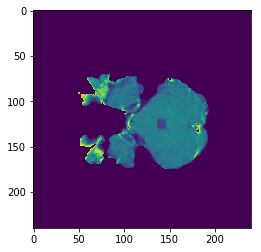

In [36]:
plt.imshow(fla.dataobj[:,:,50])

In [37]:
t1.shape

(240, 240, 160)

In [38]:
t2.shape

(240, 240, 160)

In [39]:
t1c.shape

(240, 240, 160)

In [ ]:
fla.shape == t1.shape == 